In [1]:
import pandas as pd

### 데이터 베이스 설정

In [2]:
DB_URL = 'onad.cbjjamtlar2t.ap-northeast-2.rds.amazonaws.com'
DB_USER = 'onad'
DB_PASSWORD = 'rkdghktn12'
DB_DATABASE = 'onad'
DB_CHARSET = 'utf8mb4'
DB_LOGFLAG  = 'False'
DB_PORT = 3306

db_url = "mysql+pymysql://%s:%s@%s:%s/%s?charset=%s" % (
    DB_USER, DB_PASSWORD,
    DB_URL, DB_PORT,
    DB_DATABASE, DB_CHARSET
)

In [3]:
def data_from_sql_twitchchat(streamer, target_date):
    query = """
        select * from twitch_chat where streamer_name = "%s" and broad_date ="%s"
    """% (streamer, target_date)

    return pd.read_sql_query(query, db_url)

### 채팅 데이터 로드

In [4]:
streamer = "rhdgurwns"
target_date = "2018-12-15"
chat_data = data_from_sql_twitchchat(streamer, target_date)

### Exploratory Data Analysis

In [5]:
chat_data.shape

(37888, 6)

In [6]:
chat_data.head()

,chat_id,streamer_name,broad_date,chatterer,chat_time,chat_contents
0,6063606,rhdgurwns,2018-12-15,<%업체에게쪽쪽빨린호구 (tkatjf119)>,00:38:21,?
1,6063607,rhdgurwns,2018-12-15,<구름위에카페 (navernice0723)>,05:56:09,혁준상
2,6063608,rhdgurwns,2018-12-15,<ow_easybro>,09:01:55,앵긔모씌
3,6063609,rhdgurwns,2018-12-15,<갱생병장 (tkdrl1104)>,09:47:50,혁준아 언제오냐
4,6063610,rhdgurwns,2018-12-15,<갱생병장 (tkdrl1104)>,09:48:06,!uptime


In [7]:
print("채팅 로그의 수: %s" % (chat_data.shape[0]))
print("순수 시청자 수: %s" % (len(list(chat_data['chatterer'].unique()))))

채팅 로그의 수: 37888
순수 시청자 수: 3414


In [8]:
print("채팅로그의 시작과 끝 : %s ~ %s " % (sorted(chat_data['chat_time'])[0], sorted(chat_data['chat_time'])[-1]))

채팅로그의 시작과 끝 : 00:38:21 ~ 21:02:04 


### 시간데이터를 DatetimeIndex 로 변경

In [9]:
chat_data['chat_time'] = chat_data['chat_time'].apply(lambda x : target_date + " " + x)

In [10]:
chat_data['time'] = pd.to_datetime(chat_data['chat_time'])
chat_data['time'].head(2)

0   2018-12-15 00:38:21
1   2018-12-15 05:56:09
Name: time, dtype: datetime64[ns]

In [11]:
chat_data_reindex = chat_data.set_index('time')

In [12]:
chat_data_reindex.head(2)

,chat_id,streamer_name,broad_date,chatterer,chat_time,chat_contents
time,,,,,,
2018-12-15 00:38:21,6063606,rhdgurwns,2018-12-15,<%업체에게쪽쪽빨린호구 (tkatjf119)>,2018-12-15 00:38:21,?
2018-12-15 05:56:09,6063607,rhdgurwns,2018-12-15,<구름위에카페 (navernice0723)>,2018-12-15 05:56:09,혁준상


## 분석용 데이터셋 제작

#### 1. 필요없는 행 삭제

In [13]:
# 필요없는 행 삭제
del chat_data_reindex['chat_id']
del chat_data_reindex['streamer_name']
del chat_data_reindex['broad_date']
del chat_data_reindex['chat_time']

In [14]:
chat_data_reindex.head(2)

,chatterer,chat_contents
time,,
2018-12-15 00:38:21,<%업체에게쪽쪽빨린호구 (tkatjf119)>,?
2018-12-15 05:56:09,<구름위에카페 (navernice0723)>,혁준상


#### 2. 한 문장에서 특정 단어의 수 세어 컬럼으로 생성

In [15]:
chat_data_reindex['cnt_ㅋ'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("ㅋ"))
chat_data_reindex['cnt_ㄵ'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("ㄵ"))
chat_data_reindex['cnt_ㄴㅈ'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("ㄴㅈ"))
chat_data_reindex['cnt_오'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("오"))
chat_data_reindex['cnt_와'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("와"))
chat_data_reindex['cnt_유하'] = chat_data_reindex.chat_contents.apply(lambda x : x.count("유하"))


In [16]:
chat_data_reindex.head(2)

,chatterer,chat_contents,cnt_ㅋ,cnt_ㄵ,cnt_ㄴㅈ,cnt_오,cnt_와,cnt_유하
time,,,,,,,,
2018-12-15 00:38:21,<%업체에게쪽쪽빨린호구 (tkatjf119)>,?,0,0,0,0,0,0
2018-12-15 05:56:09,<구름위에카페 (navernice0723)>,혁준상,0,0,0,0,0,0


#### 3. 해당 채팅 수 빈도를 갖는 피봇 데이터 프레임 생성

In [17]:
pivot_df = chat_data_reindex.pivot_table(index=chat_data_reindex.index, aggfunc=len, values='chatterer')
pivot_df.columns = ['cnt_chat']  # 컬럼 이름 할당
pivot_df["cnt_ㅋ"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_ㅋ')['cnt_ㅋ']
pivot_df["cnt_ㄵ"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_ㄵ')['cnt_ㄵ'] +\
                    chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_ㄴㅈ')['cnt_ㄴㅈ']
pivot_df["cnt_오"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_오')['cnt_오']
pivot_df["cnt_와"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_와')['cnt_와']
pivot_df["cnt_유하"] = chat_data_reindex.pivot_table(index = chat_data_reindex.index, aggfunc=sum, values='cnt_유하')['cnt_유하']

# 초당 채팅수가 평균 이상인 경우만 보이도록
pivot_df[pivot_df['cnt_chat'] > pivot_df['cnt_chat'].mean()]
print(sorted(pivot_df['cnt_chat'].unique(), reverse=True)[:10])
print(sorted(pivot_df['cnt_ㅋ'].unique(), reverse=True)[:10])

pivot_df.head(2)

[25, 22, 21, 19, 18, 17, 16, 15, 14, 13]
[414, 365, 236, 226, 195, 187, 181, 176, 168, 166]


,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하
time,,,,,,
2018-12-15 00:38:21,1,0,0,0,0,0
2018-12-15 05:56:09,1,0,0,0,0,0


### 검증데이터를 추가, 검증데이터와 분석데이터간 상관관계를 알아보자

- 검증데이터: yes/no 의 명목형 변수  
- 이외의 다른 열 : 연속형 변수  
명목형 변수와 연속형 변수의 상관관계의 경우 **`Point-biserial correlation`** 을 사용함  
이는 scipy.stats 모듈에 pointbiserialr 메소드로 구현되어 있음

#### 시험해보기 위한 치팅
- 채팅 수가 60% 중위수 이상인 경우 모두 하이라이트영상이 있다고 가정하여 데이터프레임 생성

In [18]:
import numpy as np
anal_df = pivot_df.copy()
percentile = np.percentile(anal_df.cnt_chat.unique(), 70)
anal_df[anal_df['cnt_chat'] > percentile].head(2)

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하
time,,,,,,
2018-12-15 13:15:37,16,16,0,0,0,0
2018-12-15 13:16:25,16,0,0,0,0,0


#### 전체 채팅 70% 보다 채팅 수가 높은 경우의 점들을 모두 yes 로

In [19]:
anal_df['validation'] = anal_df['cnt_chat'].apply(lambda x : 1 if x >= percentile else 0)

In [20]:
anal_df['validation'].unique()

array([0, 1], dtype=int64)

#### scipy.stats 불러오기

In [21]:
from scipy import stats
for col in anal_df:
    print("%s 상관 정도 : " % col, stats.pointbiserialr(anal_df[col], anal_df['validation']).correlation)

cnt_chat 상관 정도 :  0.2503603653249046
cnt_ㅋ 상관 정도 :  0.20445949254447038
cnt_ㄵ 상관 정도 :  -0.0021500155806833446
cnt_오 상관 정도 :  0.009281894601281667
cnt_와 상관 정도 :  0.09071666087105501
cnt_유하 상관 정도 :  -0.001167740234008065
validation 상관 정도 :  1.0


In [22]:
anal_df.corr()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
cnt_chat,1.000000,0.428453,0.027349,0.067837,0.166636,0.028116,0.250360
cnt_ㅋ,0.428453,1.000000,0.009147,0.003993,0.007971,-0.003505,0.204459
cnt_ㄵ,0.027349,0.009147,1.000000,-0.003497,0.010259,-0.001880,-0.002150
cnt_오,0.067837,0.003993,-0.003497,1.000000,0.013102,0.008990,0.009282
cnt_와,0.166636,0.007971,0.010259,0.013102,1.000000,-0.005046,0.090717
cnt_유하,0.028116,-0.003505,-0.001880,0.008990,-0.005046,1.000000,-0.001168
validation,0.250360,0.204459,-0.002150,0.009282,0.090717,-0.001168,1.000000


### <center>수집한 검증데이터로 상관관계알아보자</center>
<center>* 공혁준</center>

|영상날짜|영상 시작 시간|종료시간|영상길이|
|--|:---:|:---:|---|
|2018-12-09|13:24:14|18:53:34|5:29:20|
|2018-12-09|16:42:35|16:48:26|0:05:35|
|2018-12-09|17:37:25|17:44:41|0:07:16|
|2018-12-09|16:54:40|17:03:49|0:09:09|
|2018-12-09|17:17:08|17:19:08|0:02:00|

#### 유튜브 영상 시작시간과 끝 시간 딕셔너리 생성

In [53]:
# 유튜브 비디오 시작시간과 끝시간
youtube_video_time = {
    '2018-12-09 16:42:35': '2018-12-09 16:48:26',
    '2018-12-09 17:37:25': '2018-12-09 17:44:41',
    '2018-12-09 16:54:40': '2018-12-09 17:03:49',
    '2018-12-09 17:17:08': '2018-12-09 17:19:08',
}
youtube_video_time1207 = {
    '2018-12-07 14:01:07': '2018-12-07 14:04:53',
    '2018-12-07 13:39:05': '2018-12-07 13:59:53',
    '2018-12-07 12:46:18': '2018-12-07 13:11:40',
#     '2018-12-07 8:59:02': '14:15:13',
}
youtube_video_time1213 = {
    '2018-12-13 19:58:26': '2018-12-13 14:33:24',
}
youtube_video_time1215 = {
    '2018-12-15 14:29:30': '2018-12-15 14:33:24',
    '2018-12-15 14:35:25': '2018-12-15 15:01:20',
}

#### 유튜브 영상 시작, 끝 까지의 모든 초 DATETIME 생성

In [54]:
# 시작시간부터 끝 시간까지의 모든 초의 데이트타임생성
highlight_times = [pd.date_range(start=start, end=end, freq='s') for start, end in youtube_video_time1215.items()]
hl_times = []
for time in highlight_times:
    hl_times.extend(time)


In [55]:
len(hl_times), hl_times[:2]

(1791,
 [Timestamp('2018-12-15 14:29:30', freq='S'),
  Timestamp('2018-12-15 14:29:31', freq='S')])

#### 채팅로그 데이터에 유튜브 영상시간에 해당하면 validation 컬럼 1으로

In [56]:
chat_data_reindex.head(2)

,chatterer,chat_contents,cnt_ㅋ,cnt_ㄵ,cnt_ㄴㅈ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,,,
2018-12-15 00:38:21,<%업체에게쪽쪽빨린호구 (tkatjf119)>,?,0,0,0,0,0,0,0
2018-12-15 05:56:09,<구름위에카페 (navernice0723)>,혁준상,0,0,0,0,0,0,0


In [57]:
chat_data_reindex['validation'] = chat_data_reindex.index
chat_data_reindex['validation'] = chat_data_reindex['validation'].apply(lambda x : 1 if x in hl_times else 0)

In [58]:
chat_data_reindex.validation.unique()

array([0, 1], dtype=int64)

In [59]:
chat_data_reindex.corr()

,cnt_ㅋ,cnt_ㄵ,cnt_ㄴㅈ,cnt_오,cnt_와,cnt_유하,validation
cnt_ㅋ,1.000000,-0.009981,-0.007069,-0.032052,-0.034817,-0.005925,-0.040048
cnt_ㄵ,-0.009981,1.000000,-0.000655,-0.003804,-0.003591,-0.000584,-0.010927
cnt_ㄴㅈ,-0.007069,-0.000655,1.000000,-0.002939,-0.002775,-0.000451,-0.008442
cnt_오,-0.032052,-0.003804,-0.002939,1.000000,-0.003828,-0.002617,-0.015810
cnt_와,-0.034817,-0.003591,-0.002775,-0.003828,1.000000,-0.002471,-0.008962
cnt_유하,-0.005925,-0.000584,-0.000451,-0.002617,-0.002471,1.000000,0.024741
validation,-0.040048,-0.010927,-0.008442,-0.015810,-0.008962,0.024741,1.000000


#### 빈도수로 피봇된 테이블에 validation 컬럼 추가

In [60]:
anal_df.validation = anal_df.index
anal_df.validation = anal_df.validation.apply(lambda x : 1 if x in hl_times else 0)

In [61]:
anal_df.validation.unique()

array([0, 1], dtype=int64)

In [62]:
anal_df.corr()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
cnt_chat,1.000000,0.428453,0.027349,0.067837,0.166636,0.028116,0.030420
cnt_ㅋ,0.428453,1.000000,0.009147,0.003993,0.007971,-0.003505,-0.031910
cnt_ㄵ,0.027349,0.009147,1.000000,-0.003497,0.010259,-0.001880,-0.021254
cnt_오,0.067837,0.003993,-0.003497,1.000000,0.013102,0.008990,-0.021141
cnt_와,0.166636,0.007971,0.010259,0.013102,1.000000,-0.005046,-0.007894
cnt_유하,0.028116,-0.003505,-0.001880,0.008990,-0.005046,1.000000,0.041387
validation,0.030420,-0.031910,-0.021254,-0.021141,-0.007894,0.041387,1.000000


In [63]:
anal_df[anal_df['cnt_chat'] > 30]

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,


In [64]:
# 유튜브 영상이 존재하는지 여부를 중심으로 데이터 분할
yes_data = anal_df[anal_df['validation'] == 1]
no_data = anal_df[anal_df['validation'] == 0]

# 분할된 데이터 인덱스를 시간으로만 변경
# no_data.index = [i.time() for i in no_data.index]
# yes_data.index = [i.time() for i in yes_data.index]

In [65]:
no_data.head()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,
2018-12-15 00:38:21,1,0,0,0,0,0,0
2018-12-15 05:56:09,1,0,0,0,0,0,0
2018-12-15 09:01:55,1,0,0,0,0,0,0
2018-12-15 09:47:50,1,0,0,1,0,0,0
2018-12-15 09:48:06,1,0,0,0,0,0,0


In [66]:
# 등분산 검정
for i in anal_df:
    print("%s_pvalue: " % i, stats.bartlett(yes_data[i], no_data[i]).pvalue)
    if stats.bartlett(yes_data[i], no_data[i]).pvalue < 0.01: print("유의함")

cnt_chat_pvalue:  1.2094460372658519e-19
유의함
cnt_ㅋ_pvalue:  1.9014321061653052e-22
유의함
cnt_ㄵ_pvalue:  0.0
유의함
cnt_오_pvalue:  1.68018374052508e-06
유의함
cnt_와_pvalue:  3.084823167790185e-62
유의함
cnt_유하_pvalue:  0.0
유의함
validation_pvalue:  nan


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1852: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [67]:
# 정규성 검정
# Kolmogorov-Smirnov 검정은 사실 정규 분포에 국한되지 않고 두 표본이 같은 분포를 따르는지 확인할 수 있는 방법이다. 
# scipy.stats.ks_2samp()
for i in anal_df:
    print("%s_pvalue: "% i, stats.ks_2samp(yes_data[i], no_data[i]))
    if stats.ks_2samp(yes_data[i], no_data[i]).pvalue < 0.01: print("유의함")

cnt_chat_pvalue:  Ks_2sampResult(statistic=0.12004277412782594, pvalue=8.654719112986728e-18)
유의함
cnt_ㅋ_pvalue:  Ks_2sampResult(statistic=0.06702337584791107, pvalue=7.73028425602356e-06)
유의함
cnt_ㄵ_pvalue:  Ks_2sampResult(statistic=0.004189008042895459, pvalue=1.0)
cnt_오_pvalue:  Ks_2sampResult(statistic=0.014742081860637968, pvalue=0.9237351013066842)
cnt_와_pvalue:  Ks_2sampResult(statistic=0.002095902149934492, pvalue=0.9999999999999999)
cnt_유하_pvalue:  Ks_2sampResult(statistic=0.004548327063981783, pvalue=1.0)
validation_pvalue:  Ks_2sampResult(statistic=1.0, pvalue=0.0)
유의함


In [68]:
# ttest
for i in anal_df:
    print(stats.ttest_ind(yes_data[i], no_data[i]))
    if stats.ttest_ind(yes_data[i], no_data[i]).pvalue < 0.01: print("유의함")    

Ttest_indResult(statistic=3.5350494889066018, pvalue=0.00040906429707951366)
유의함
Ttest_indResult(statistic=-3.7084500925039876, pvalue=0.00020936755961593038)
유의함
Ttest_indResult(statistic=-2.469314792300396, pvalue=0.013549495945113474)
Ttest_indResult(statistic=-2.4561841675860925, pvalue=0.014054627160502845)
Ttest_indResult(statistic=-0.9169632948327949, pvalue=0.35917826444145606)
Ttest_indResult(statistic=4.811489998989973, pvalue=1.5143032181985728e-06)
유의함
Ttest_indResult(statistic=inf, pvalue=0.0)
유의함


In [69]:
yes_data.describe()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
count,1558.000000,1558.000000,1558.0,1558.000000,1558.000000,1558.000000,1558.0
mean,3.000642,3.543004,0.0,0.036585,0.037227,0.005777,1.0
std,1.945137,12.070246,0.0,0.219351,0.199294,0.083854,0.0
min,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
25%,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
50%,3.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
75%,4.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0
max,12.000000,120.000000,0.0,5.000000,2.000000,2.000000,1.0


In [70]:
no_data.describe()

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
count,11936.000000,11936.000000,11936.000000,11936.000000,11936.000000,11936.000000,11936.0
mean,2.782590,4.981149,0.004608,0.052363,0.043985,0.000670,0.0
std,2.331059,14.672669,0.073654,0.240839,0.281820,0.028938,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,25.000000,414.000000,2.000000,4.000000,10.000000,2.000000,0.0


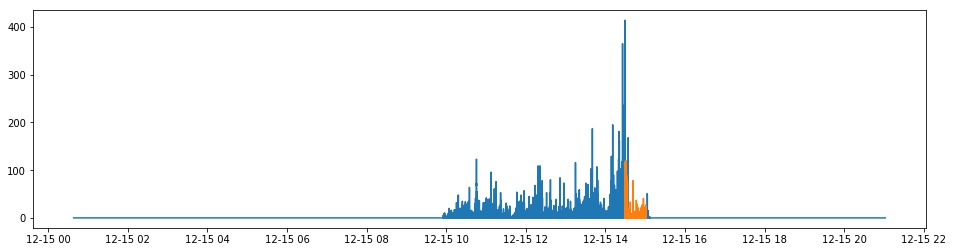

In [71]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(no_data.index, no_data['cnt_ㅋ'])
plt.plot(yes_data.index, yes_data['cnt_ㅋ'])
plt.show()


In [72]:
no_data[no_data['cnt_ㅋ'] > 200]

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,
2018-12-15 14:25:56,21,365,0,0,0,0,0
2018-12-15 14:28:01,21,226,0,0,0,0,0
2018-12-15 14:28:02,11,236,0,0,0,0,0
2018-12-15 14:29:25,25,414,0,0,0,0,0


In [73]:
chat_data_reindex[chat_data_reindex.index=="2018-12-07 13:36:19"]

,chatterer,chat_contents,cnt_ㅋ,cnt_ㄵ,cnt_ㄴㅈ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,,,


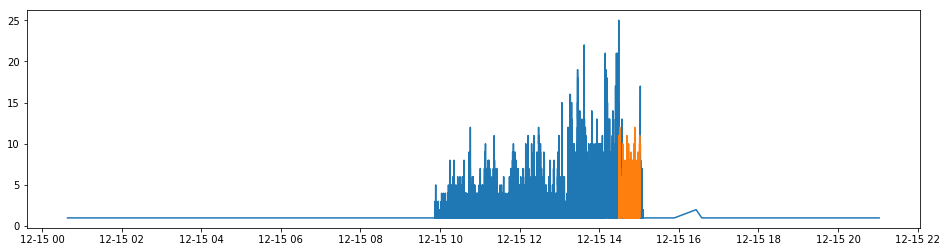

In [74]:
plt.figure(figsize=(16,4))
plt.plot(no_data.index, no_data['cnt_chat'])
plt.plot(yes_data.index, yes_data['cnt_chat'])
plt.show()


In [45]:
anal_df[anal_df['validation'] == 0][:5]

,cnt_chat,cnt_ㅋ,cnt_ㄵ,cnt_오,cnt_와,cnt_유하,validation
time,,,,,,,
2018-12-15 00:38:21,1,0,0,0,0,0,0
2018-12-15 05:56:09,1,0,0,0,0,0,0
2018-12-15 09:01:55,1,0,0,0,0,0,0
2018-12-15 09:47:50,1,0,0,1,0,0,0
2018-12-15 09:48:06,1,0,0,0,0,0,0


In [75]:
anal_df.to_csv("rhdgurwns_2019_12_15.csv")